In [ ]:
"""
СКРИПТ 1: УСТАНОВКА И ЗАГРУЗКА МОДЕЛИ
Запустить ОДИН РАЗ в начале работы
"""
!pip install -q transformers accelerate torch pandas numpy tqdm openpyxl

import torch
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForCausalLM
import math
import gc
import os
from tqdm import tqdm

# Глобальные переменные
GLOBAL_TOKENIZER = None
GLOBAL_MODEL = None
GLOBAL_DEVICE = None

def load_model(model_name="IlyaGusev/rugpt3medium_sum_gazeta"):
    """Загружает русскоязычную модель"""
    global GLOBAL_TOKENIZER, GLOBAL_MODEL, GLOBAL_DEVICE

    print(f"🤖 Загрузка модели: {model_name}")
    GLOBAL_TOKENIZER = AutoTokenizer.from_pretrained(model_name)
    GLOBAL_TOKENIZER.pad_token = GLOBAL_TOKENIZER.eos_token

    GLOBAL_DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"📟 Устройство: {GLOBAL_DEVICE}")

    GLOBAL_MODEL = AutoModelForCausalLM.from_pretrained(
        model_name,
        torch_dtype=torch.float16 if GLOBAL_DEVICE == "cuda" else torch.float32
    ).to(GLOBAL_DEVICE)
    GLOBAL_MODEL.eval()

    print(f"✅ Модель загружена. Словарь: {GLOBAL_MODEL.config.vocab_size} токенов")
    return GLOBAL_TOKENIZER, GLOBAL_MODEL, GLOBAL_DEVICE

# Автозагрузка модели
GLOBAL_TOKENIZER, GLOBAL_MODEL, GLOBAL_DEVICE = load_model()

🤖 Загрузка модели: IlyaGusev/rugpt3medium_sum_gazeta
📟 Устройство: cpu


pytorch_model.bin:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/293 [00:00<?, ?it/s]

The tied weights mapping and config for this model specifies to tie transformer.wte.weight to lm_head.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning
GPT2LMHeadModel LOAD REPORT from: IlyaGusev/rugpt3medium_sum_gazeta
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
transformer.h.{0...23}.attn.masked_bias | UNEXPECTED |  | 
transformer.h.{0...23}.attn.bias        | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


✅ Модель загружена. Словарь: 50257 токенов


In [ ]:
"""
СКРИПТ 2: ЗАГРУЗКА EXCEL И ИЗВЛЕЧЕНИЕ ТЕКСТОВ
Простая и надёжная загрузка
"""
from google.colab import files
import pandas as pd
import io

print("=" * 60)
print("📤 ЗАГРУЗКА EXCEL-ФАЙЛА")

# Загрузка файла
uploaded = files.upload()
file_name = list(uploaded.keys())[0]

print(f"✅ Загружен файл: {file_name}")

def extract_texts_simple(file_path):
    """Извлекает тексты согласно структуре файла"""
    print("\n📖 Извлечение текстов...")

    # Читаем KeyList
    key_df = pd.read_excel(file_path, sheet_name='KeyList')
    print(f"📋 Найдено записей в KeyList: {len(key_df)}")

    texts = {}

    for idx, row in key_df.iterrows():
        # Пропускаем заголовок
        if row['textSheet'] == 'textSheet' or pd.isna(row['textSheet']):
            continue

        text_id = str(row['textSheet'])
        title = str(row['Titles'])

        print(f"  🔍 Обработка: {text_id} - '{title}'")

        try:
            # Читаем лист с текстом
            df = pd.read_excel(file_path, sheet_name=text_id)

            # Собираем текст: сначала по столбцам, потом по строкам
            text_parts = []

            # Перебираем столбцы (обычно A-J)
            for col in df.columns:
                # Собираем все строки в столбце
                column_words = df[col].dropna().astype(str).tolist()

                # Добавляем с пробелом между словами
                if column_words:
                    text_parts.extend(column_words)

            # Объединяем все слова
            full_text = ' '.join(text_parts)

            # Базовая очистка
            full_text = ' '.join(full_text.split())

            texts[text_id] = {
                'title': title,
                'text': full_text,
                'word_count': len(text_parts),
                'char_count': len(full_text)
            }

            print(f"     ✓ Слов: {len(text_parts)}, Символов: {len(full_text)}")
            print(f"     📝 Начало: {full_text[:80]}...")

        except Exception as e:
            print(f"     ✗ Ошибка: {e}")
            texts[text_id] = {
                'title': title,
                'text': '',
                'error': str(e)
            }

    print(f"\n✅ Извлечено текстов: {len(texts)}")
    return texts

# Извлекаем тексты
GLOBAL_TEXTS = extract_texts_simple(file_name)

# Сохраняем информацию для отладки
print("\n📋 ИТОГИ ЗАГРУЗКИ:")
for text_id, info in GLOBAL_TEXTS.items():
    if 'error' not in info:
        print(f"  {text_id}: {info['word_count']} слов")

📤 ЗАГРУЗКА EXCEL-ФАЙЛА


Saving data_exp.xlsx to data_exp (1).xlsx
✅ Загружен файл: data_exp (1).xlsx

📖 Извлечение текстов...
📋 Найдено записей в KeyList: 30
  🔍 Обработка: Text_1 - 'Оборотни без погон'
     ✓ Слов: 151, Символов: 1109
     📝 Начало: Нерядовое задержание осуществили правоохранительные органы в Тамбовской области....
  🔍 Обработка: Text_2 - 'Призрак озеры'
     ✓ Слов: 154, Символов: 1039
     📝 Начало: Однажды в штате Луизиана (США) под землю ушло целое озеро. Из-за ошибки в расчет...
  🔍 Обработка: Text_3 - 'Лесенка-чудесенка'
     ✓ Слов: 158, Символов: 958
     📝 Начало: Ниночка – это девочка 7 лет, она любит шалить и не любит убираться в комнате. В ...
  🔍 Обработка: Text_4 - 'Футбольные правила'
     ✓ Слов: 147, Символов: 964
     📝 Начало: Футбол - один из самых популярных видов спорта. Чемпионаты мира или Европы по зр...
  🔍 Обработка: Text_5 - 'Вклад в победу'
     ✓ Слов: 154, Символов: 1083
     📝 Начало: Одним из ключевых сражений Второй мировой войны была битва под Сталинградом, 

In [ ]:
"""
СКРИПТ 3: ОБРАБОТКА ВСЕХ ТЕКСТОВ
Основная функция расчёта вероятностей
"""
import torch
import pandas as pd
import math
import gc
from tqdm import tqdm

print("=" * 60)
print("🚀 НАЧАЛО ОБРАБОТКИ ВСЕХ ТЕКСТОВ")

# Проверяем загрузку
if 'GLOBAL_TEXTS' not in globals() or not GLOBAL_TEXTS:
    print("❌ Тексты не загружены! Запустите script2_load_excel.py")
    raise SystemExit

if 'GLOBAL_MODEL' not in globals():
    print("❌ Модель не загружена! Запустите script1_setup.py")
    raise SystemExit

def calculate_surprisal(probability):
    """Рассчитывает surprisal (неожиданность) из вероятности"""
    if probability <= 0:
        return float('inf')
    return -math.log2(probability)

def process_single_text(text, text_id, max_tokens=512):
    """Обрабатывает один текст и возвращает DataFrame"""
    print(f"\n🔹 Обработка: {text_id}")
    print(f"   📏 Длина: {len(text)} символов")

    if not text or len(text.strip()) == 0:
        print("   ⚠️  Текст пуст, пропускаем")
        return None

    # Токенизация
    inputs = GLOBAL_TOKENIZER(text, return_tensors="pt", truncation=True, max_length=max_tokens)
    input_ids = inputs.input_ids.to(GLOBAL_DEVICE)
    seq_len = input_ids.shape[1]

    print(f"   🔤 Токенов: {seq_len}")

    results = []

    # Обработка каждого токена
    with torch.no_grad():
        for i in tqdm(range(1, seq_len), desc=f"Токены {text_id}", leave=False):
            # Берем контекст до текущего токена
            prefix = input_ids[:, :i]

            # Прогноз модели
            outputs = GLOBAL_MODEL(prefix)
            logits = outputs.logits

            # Вероятности для следующего токена
            next_token_logits = logits[0, -1, :]
            next_token_probs = torch.softmax(next_token_logits, dim=-1)

            # Истинный токен
            target_id = input_ids[0, i].item()
            prob = next_token_probs[target_id].item()

            # Decode токена
            token_str = GLOBAL_TOKENIZER.decode([target_id], skip_special_tokens=True)

            # Рассчитываем неожиданность
            surprisal = calculate_surprisal(prob)

            results.append({
                'text_id': text_id,
                'position': i + 1,  # Начинаем с 1
                'token': token_str.strip(),
                'token_id': target_id,
                'probability': prob,
                'log_probability': math.log(prob) if prob > 0 else float('-inf'),
                'surprisal': surprisal
            })

    if results:
        df = pd.DataFrame(results)

        # Статистика
        avg_prob = df['probability'].mean()
        avg_surprisal = df['surprisal'].mean()
        min_prob = df['probability'].min()
        max_surprisal = df['surprisal'].max()

        print(f"   📊 Статистика:")
        print(f"      • Средняя вероятность: {avg_prob:.6f}")
        print(f"      • Средняя неожиданность: {avg_surprisal:.2f} бит")
        print(f"      • Минимальная вероятность: {min_prob:.6f}")
        print(f"      • Максимальная неожиданность: {max_surprisal:.2f} бит")
        print(f"      • Токенов с максимальной неожиданностью: {len(df[df['surprisal'] > 10])}")

        # Показываем самые неожиданные токены
        if max_surprisal > 10:
            top_surprising = df.nlargest(3, 'surprisal')
            print(f"      • Самые неожиданные токены:")
            for _, row in top_surprising.iterrows():
                token_display = repr(row['token'])[1:-1]
                print(f"        '{token_display}': {row['surprisal']:.1f} бит")

    return pd.DataFrame(results) if results else None

def process_all_texts(force_reprocess=False):
    """Обрабатывает все тексты"""
    all_results = []
    processed = []
    failed = []

    print(f"\n📊 ОБРАБОТКА {len(GLOBAL_TEXTS)} ТЕКСТОВ")
    print("=" * 40)

    for text_id, info in tqdm(GLOBAL_TEXTS.items(), desc="Тексты"):
        output_file = f"{text_id}_probabilities.csv"

        # Пропускаем уже обработанные
        if not force_reprocess and os.path.exists(output_file):
            print(f"\n⏭️  Пропускаем (уже обработан): {text_id}")
            try:
                df = pd.read_csv(output_file)
                all_results.append(df)
                processed.append(text_id)
            except:
                pass
            continue

        if 'error' in info:
            print(f"\n⚠️  Пропускаем (ошибка загрузки): {text_id}")
            failed.append(text_id)
            continue

        # Обработка текста
        try:
            df = process_single_text(info['text'], text_id)

            if df is not None:
                df.insert(0, 'title', info['title'])
                df.to_csv(output_file, index=False, encoding='utf-8-sig')
                all_results.append(df)
                processed.append(text_id)
                print(f"   💾 Сохранено: {output_file}")
            else:
                failed.append(text_id)

        except Exception as e:
            print(f"\n❌ Ошибка обработки {text_id}: {e}")
            failed.append(text_id)

        # Очистка памяти
        if GLOBAL_DEVICE == "cuda":
            torch.cuda.empty_cache()
        gc.collect()

    # Сводная статистика
    print("\n" + "=" * 60)
    print("📈 ИТОГИ ОБРАБОТКИ:")
    print(f"   ✅ Успешно: {len(processed)} текстов")
    print(f"   ❌ Не удалось: {len(failed)} текстов")

    if processed:
        # Объединяем все результаты
        if all_results:
            combined_df = pd.concat(all_results, ignore_index=True)

            # Общая статистика
            print(f"\n📊 ОБЩАЯ СТАТИСТИКА:")
            print(f"   • Всего токенов: {len(combined_df):,}")
            print(f"   • Средняя вероятность: {combined_df['probability'].mean():.6f}")
            print(f"   • Средняя неожиданность: {combined_df['surprisal'].mean():.2f} бит")
            print(f"   • Общий диапазон: {combined_df['probability'].min():.6f} - {combined_df['probability'].max():.6f}")

            # Статистика по текстам
            summary = combined_df.groupby('text_id').agg({
                'probability': ['count', 'mean', 'std', 'min', 'max'],
                'surprisal': ['mean', 'max']
            }).round(6)

            summary.columns = ['tokens', 'prob_mean', 'prob_std', 'prob_min', 'prob_max',
                              'surp_mean', 'surp_max']
            summary = summary.reset_index()

            summary_file = "processing_summary.csv"
            summary.to_csv(summary_file, index=False, encoding='utf-8-sig')
            print(f"\n📋 Сводная статистика сохранена: {summary_file}")
            print(summary.to_string())

    return all_results

# Запуск обработки
try:
    results = process_all_texts(force_reprocess=False)
    print("\n🎉 ОБРАБОТКА ЗАВЕРШЕНА!")
except KeyboardInterrupt:
    print("\n⚠️  ОБРАБОТКА ПРЕРВАНА ПОЛЬЗОВАТЕЛЕМ")
except Exception as e:
    print(f"\n❌ ОШИБКА: {e}")

🚀 НАЧАЛО ОБРАБОТКИ ВСЕХ ТЕКСТОВ

📊 ОБРАБОТКА 30 ТЕКСТОВ


Тексты:   0%|          | 0/30 [00:00<?, ?it/s]


🔹 Обработка: Text_1
   📏 Длина: 1109 символов
   🔤 Токенов: 225



Токены Text_1: 100%|██████████| 224/224 [07:31<00:00,  3.51s/it]
                                                                

   📊 Статистика:
      • Средняя вероятность: 0.366198
      • Средняя неожиданность: 4.49 бит
      • Минимальная вероятность: 0.000000
      • Максимальная неожиданность: 23.09 бит
      • Токенов с максимальной неожиданностью: 37
      • Самые неожиданные токены:
        'планета': 23.1 бит
        'чё': 18.6 бит
        'людьми': 17.9 бит
   💾 Сохранено: Text_1_probabilities.csv


Тексты:   3%|▎         | 1/30 [07:32<3:38:40, 452.42s/it]


🔹 Обработка: Text_2
   📏 Длина: 1039 символов
   🔤 Токенов: 236



Токены Text_2: 100%|██████████| 235/235 [08:12<00:00,  3.67s/it]
                                                                

   📊 Статистика:
      • Средняя вероятность: 0.345180
      • Средняя неожиданность: 4.47 бит
      • Минимальная вероятность: 0.000000
      • Максимальная неожиданность: 22.19 бит
      • Токенов с максимальной неожиданностью: 35
      • Самые неожиданные токены:
        '55': 22.2 бит
        'ёр': 20.0 бит
        'огромную': 19.2 бит
   💾 Сохранено: Text_2_probabilities.csv


Тексты:   7%|▋         | 2/30 [15:45<3:42:10, 476.07s/it]


🔹 Обработка: Text_3
   📏 Длина: 958 символов
   🔤 Токенов: 240



Тексты:  10%|█         | 3/30 [24:19<3:42:12, 493.80s/it]

   📊 Статистика:
      • Средняя вероятность: 0.302283
      • Средняя неожиданность: 4.52 бит
      • Минимальная вероятность: 0.000004
      • Максимальная неожиданность: 18.04 бит
      • Токенов с максимальной неожиданностью: 32
      • Самые неожиданные токены:
        'школа': 18.0 бит
        'ждёт': 17.9 бит
        'ох': 17.1 бит
   💾 Сохранено: Text_3_probabilities.csv

🔹 Обработка: Text_4
   📏 Длина: 964 символов
   🔤 Токенов: 198



Токены Text_4: 100%|██████████| 197/197 [06:08<00:00,  3.19s/it]
                                                                

   📊 Статистика:
      • Средняя вероятность: 0.352640
      • Средняя неожиданность: 4.07 бит
      • Минимальная вероятность: 0.000001
      • Максимальная неожиданность: 19.36 бит
      • Токенов с максимальной неожиданностью: 25
      • Самые неожиданные токены:
        'призна': 19.4 бит
        'площади': 19.1 бит
        'рядом': 16.9 бит
   💾 Сохранено: Text_4_probabilities.csv


Тексты:  13%|█▎        | 4/30 [30:28<3:12:35, 444.45s/it]


🔹 Обработка: Text_5
   📏 Длина: 1083 символов
   🔤 Токенов: 230



Токены Text_5: 100%|██████████| 229/229 [07:56<00:00,  3.58s/it]
                                                                

   📊 Статистика:
      • Средняя вероятность: 0.395715
      • Средняя неожиданность: 4.03 бит
      • Минимальная вероятность: 0.000001
      • Максимальная неожиданность: 20.04 бит
      • Токенов с максимальной неожиданностью: 32
      • Самые неожиданные токены:
        'жив': 20.0 бит
        'осторож': 18.7 бит
        'солом': 18.0 бит
   💾 Сохранено: Text_5_probabilities.csv


Тексты:  17%|█▋        | 5/30 [38:25<3:10:00, 456.02s/it]


🔹 Обработка: Text_6
   📏 Длина: 945 символов
   🔤 Токенов: 210



Токены Text_6: 100%|██████████| 209/209 [06:39<00:00,  3.45s/it]
                                                                

   📊 Статистика:
      • Средняя вероятность: 0.388741
      • Средняя неожиданность: 3.90 бит
      • Минимальная вероятность: 0.000010
      • Максимальная неожиданность: 16.62 бит
      • Токенов с максимальной неожиданностью: 26
      • Самые неожиданные токены:
        'американ': 16.6 бит
        'шестой': 16.2 бит
        'иногда': 15.3 бит
   💾 Сохранено: Text_6_probabilities.csv


Тексты:  20%|██        | 6/30 [45:05<2:54:50, 437.12s/it]


🔹 Обработка: Text_7
   📏 Длина: 1069 символов
   🔤 Токенов: 230



Токены Text_7: 100%|██████████| 229/229 [08:01<00:00,  3.76s/it]
                                                                

   📊 Статистика:
      • Средняя вероятность: 0.389188
      • Средняя неожиданность: 3.91 бит
      • Минимальная вероятность: 0.000001
      • Максимальная неожиданность: 19.96 бит
      • Токенов с максимальной неожиданностью: 23
      • Самые неожиданные токены:
        'потя': 20.0 бит
        'Нах': 18.6 бит
        'указ': 16.9 бит
   💾 Сохранено: Text_7_probabilities.csv


Тексты:  23%|██▎       | 7/30 [53:08<2:53:14, 451.95s/it]


🔹 Обработка: Text_8
   📏 Длина: 1002 символов
   🔤 Токенов: 210



Токены Text_8: 100%|██████████| 209/209 [06:47<00:00,  3.37s/it]
                                                                

   📊 Статистика:
      • Средняя вероятность: 0.286932
      • Средняя неожиданность: 4.61 бит
      • Минимальная вероятность: 0.000007
      • Максимальная неожиданность: 17.21 бит
      • Токенов с максимальной неожиданностью: 31
      • Самые неожиданные токены:
        'кот': 17.2 бит
        'Бел': 15.7 бит
        'высшую': 15.4 бит
   💾 Сохранено: Text_8_probabilities.csv


Тексты:  27%|██▋       | 8/30 [59:56<2:40:34, 437.93s/it]


🔹 Обработка: Text_9
   📏 Длина: 978 символов
   🔤 Токенов: 248



Тексты:  30%|███       | 9/30 [1:09:06<2:45:35, 473.11s/it]

   📊 Статистика:
      • Средняя вероятность: 0.301991
      • Средняя неожиданность: 4.86 бит
      • Минимальная вероятность: 0.000001
      • Максимальная неожиданность: 20.89 бит
      • Токенов с максимальной неожиданностью: 36
      • Самые неожиданные токены:
        'лё': 20.9 бит
        'Россию': 18.8 бит
        'пре': 17.7 бит
   💾 Сохранено: Text_9_probabilities.csv

🔹 Обработка: Text_10
   📏 Длина: 981 символов
   🔤 Токенов: 224



Токены Text_10: 100%|██████████| 223/223 [07:39<00:00,  3.65s/it]
                                                                 

   📊 Статистика:
      • Средняя вероятность: 0.448835
      • Средняя неожиданность: 3.17 бит
      • Минимальная вероятность: 0.000012
      • Максимальная неожиданность: 16.33 бит
      • Токенов с максимальной неожиданностью: 13
      • Самые неожиданные токены:
        'бор': 16.3 бит
        'фильмы': 16.0 бит
        'цуз': 15.5 бит
   💾 Сохранено: Text_10_probabilities.csv


Тексты:  33%|███▎      | 10/30 [1:16:46<2:36:23, 469.17s/it]


🔹 Обработка: Text_11
   📏 Длина: 951 символов
   🔤 Токенов: 206



Токены Text_11: 100%|██████████| 205/205 [06:36<00:00,  3.36s/it]
                                                                 

   📊 Статистика:
      • Средняя вероятность: 0.312405
      • Средняя неожиданность: 4.24 бит
      • Минимальная вероятность: 0.000010
      • Максимальная неожиданность: 16.61 бит
      • Токенов с максимальной неожиданностью: 17
      • Самые неожиданные токены:
        'приём': 16.6 бит
        'предыдущие': 15.4 бит
        'зары': 14.4 бит
   💾 Сохранено: Text_11_probabilities.csv


Тексты:  37%|███▋      | 11/30 [1:23:23<2:21:31, 446.94s/it]


🔹 Обработка: Text_12
   📏 Длина: 989 символов
   🔤 Токенов: 245



Токены Text_12: 100%|██████████| 244/244 [08:58<00:00,  3.95s/it]
                                                                 

   📊 Статистика:
      • Средняя вероятность: 0.337649
      • Средняя неожиданность: 4.43 бит
      • Минимальная вероятность: 0.000001
      • Максимальная неожиданность: 19.77 бит
      • Токенов с максимальной неожиданностью: 36
      • Самые неожиданные токены:
        'подходит': 19.8 бит
        'меньше': 18.0 бит
        'скатер': 17.4 бит
   💾 Сохранено: Text_12_probabilities.csv


Тексты:  40%|████      | 12/30 [1:32:22<2:22:28, 474.94s/it]


🔹 Обработка: Text_13
   📏 Длина: 976 символов
   🔤 Токенов: 213



Токены Text_13: 100%|██████████| 212/212 [06:57<00:00,  3.46s/it]
                                                                 

   📊 Статистика:
      • Средняя вероятность: 0.295158
      • Средняя неожиданность: 4.50 бит
      • Минимальная вероятность: 0.000002
      • Максимальная неожиданность: 19.11 бит
      • Токенов с максимальной неожиданностью: 25
      • Самые неожиданные токены:
        'мор': 19.1 бит
        'лод': 15.1 бит
        'руж': 15.1 бит
   💾 Сохранено: Text_13_probabilities.csv


Тексты:  43%|████▎     | 13/30 [1:39:20<2:09:42, 457.82s/it]


🔹 Обработка: Text_14
   📏 Длина: 1179 символов
   🔤 Токенов: 237



Токены Text_14: 100%|██████████| 236/236 [08:17<00:00,  3.66s/it]
                                                                 

   📊 Статистика:
      • Средняя вероятность: 0.391424
      • Средняя неожиданность: 4.39 бит
      • Минимальная вероятность: 0.000000
      • Максимальная неожиданность: 22.53 бит
      • Токенов с максимальной неожиданностью: 36
      • Самые неожиданные токены:
        'реф': 22.5 бит
        'тран': 19.3 бит
        'улич': 19.2 бит
   💾 Сохранено: Text_14_probabilities.csv


Тексты:  47%|████▋     | 14/30 [1:47:38<2:05:19, 469.96s/it]


🔹 Обработка: Text_15
   📏 Длина: 1035 символов
   🔤 Токенов: 237



Токены Text_15: 100%|██████████| 236/236 [08:20<00:00,  3.85s/it]
                                                                 

   📊 Статистика:
      • Средняя вероятность: 0.375392
      • Средняя неожиданность: 4.32 бит
      • Минимальная вероятность: 0.000004
      • Максимальная неожиданность: 18.07 бит
      • Токенов с максимальной неожиданностью: 31
      • Самые неожиданные токены:
        'коле': 18.1 бит
        'мадемуазель': 16.6 бит
        'полум': 16.5 бит
   💾 Сохранено: Text_15_probabilities.csv


Тексты:  50%|█████     | 15/30 [1:55:59<1:59:50, 479.35s/it]


🔹 Обработка: Text_16
   📏 Длина: 1026 символов
   🔤 Токенов: 242



Токены Text_16: 100%|██████████| 241/241 [08:34<00:00,  3.74s/it]
                                                                 

   📊 Статистика:
      • Средняя вероятность: 0.334147
      • Средняя неожиданность: 4.65 бит
      • Минимальная вероятность: 0.000001
      • Максимальная неожиданность: 20.59 бит
      • Токенов с максимальной неожиданностью: 36
      • Самые неожиданные токены:
        'застыли': 20.6 бит
        'руб': 18.8 бит
        'кровож': 18.1 бит
   💾 Сохранено: Text_16_probabilities.csv


Тексты:  53%|█████▎    | 16/30 [2:04:35<1:54:21, 490.14s/it]


🔹 Обработка: Text_17
   📏 Длина: 990 символов
   🔤 Токенов: 221



Токены Text_17: 100%|██████████| 220/220 [07:15<00:00,  3.52s/it]
                                                                 

   📊 Статистика:
      • Средняя вероятность: 0.311904
      • Средняя неожиданность: 5.00 бит
      • Минимальная вероятность: 0.000002
      • Максимальная неожиданность: 19.24 бит
      • Токенов с максимальной неожиданностью: 36
      • Самые неожиданные токены:
        'Мэр': 19.2 бит
        'убийство': 19.1 бит
        'док': 17.5 бит
   💾 Сохранено: Text_17_probabilities.csv


Тексты:  57%|█████▋    | 17/30 [2:11:51<1:42:40, 473.85s/it]


🔹 Обработка: Text_18
   📏 Длина: 1095 символов
   🔤 Токенов: 233



Токены Text_18: 100%|██████████| 232/232 [08:05<00:00,  3.54s/it]
                                                                 

   📊 Статистика:
      • Средняя вероятность: 0.357490
      • Средняя неожиданность: 4.13 бит
      • Минимальная вероятность: 0.000001
      • Максимальная неожиданность: 19.89 бит
      • Токенов с максимальной неожиданностью: 28
      • Самые неожиданные токены:
        'ворон': 19.9 бит
        'сельскохозяй': 17.4 бит
        'процедуру': 16.2 бит
   💾 Сохранено: Text_18_probabilities.csv


Тексты:  60%|██████    | 18/30 [2:19:56<1:35:28, 477.40s/it]


🔹 Обработка: Text_19
   📏 Длина: 926 символов
   🔤 Токенов: 230



Токены Text_19: 100%|██████████| 229/229 [07:50<00:00,  3.63s/it]
                                                                 

   📊 Статистика:
      • Средняя вероятность: 0.283119
      • Средняя неожиданность: 4.87 бит
      • Минимальная вероятность: 0.000000
      • Максимальная неожиданность: 21.37 бит
      • Токенов с максимальной неожиданностью: 40
      • Самые неожиданные токены:
        'клин': 21.4 бит
        'порос': 20.9 бит
        'держал': 19.5 бит
   💾 Сохранено: Text_19_probabilities.csv


Тексты:  63%|██████▎   | 19/30 [2:27:47<1:27:09, 475.41s/it]


🔹 Обработка: Text_20
   📏 Длина: 992 символов
   🔤 Токенов: 201



Токены Text_20: 100%|██████████| 200/200 [06:12<00:00,  3.28s/it]
                                                                 

   📊 Статистика:
      • Средняя вероятность: 0.319827
      • Средняя неожиданность: 4.52 бит
      • Минимальная вероятность: 0.000011
      • Максимальная неожиданность: 16.53 бит
      • Токенов с максимальной неожиданностью: 29
      • Самые неожиданные токены:
        'стеклянные': 16.5 бит
        'прести': 15.7 бит
        'зам': 15.0 бит
   💾 Сохранено: Text_20_probabilities.csv


Тексты:  67%|██████▋   | 20/30 [2:34:00<1:14:05, 444.58s/it]


🔹 Обработка: Text_21
   📏 Длина: 964 символов
   🔤 Токенов: 220



Токены Text_21: 100%|██████████| 219/219 [07:14<00:00,  3.45s/it]
                                                                 

   📊 Статистика:
      • Средняя вероятность: 0.356259
      • Средняя неожиданность: 4.26 бит
      • Минимальная вероятность: 0.000001
      • Максимальная неожиданность: 20.52 бит
      • Токенов с максимальной неожиданностью: 28
      • Самые неожиданные токены:
        'ора': 20.5 бит
        'закус': 18.0 бит
        'тет': 16.3 бит
   💾 Сохранено: Text_21_probabilities.csv


Тексты:  70%|███████   | 21/30 [2:41:15<1:06:16, 441.80s/it]


🔹 Обработка: Text_22
   📏 Длина: 997 символов
   🔤 Токенов: 207



Токены Text_22: 100%|██████████| 206/206 [06:31<00:00,  3.32s/it]
                                                                 

   📊 Статистика:
      • Средняя вероятность: 0.222132
      • Средняя неожиданность: 5.48 бит
      • Минимальная вероятность: 0.000000
      • Максимальная неожиданность: 28.83 бит
      • Токенов с максимальной неожиданностью: 36
      • Самые неожиданные токены:
        'встал': 28.8 бит
        'расчёт': 19.7 бит
        'сл': 18.8 бит
   💾 Сохранено: Text_22_probabilities.csv


Тексты:  73%|███████▎  | 22/30 [2:47:47<56:54, 426.76s/it]  


🔹 Обработка: Text_23
   📏 Длина: 1088 символов
   🔤 Токенов: 223



Токены Text_23: 100%|██████████| 222/222 [07:24<00:00,  3.60s/it]
                                                                 

   📊 Статистика:
      • Средняя вероятность: 0.379819
      • Средняя неожиданность: 4.02 бит
      • Минимальная вероятность: 0.000001
      • Максимальная неожиданность: 20.78 бит
      • Токенов с максимальной неожиданностью: 31
      • Самые неожиданные токены:
        'нынешнее': 20.8 бит
        'деревянного': 16.9 бит
        'совсем': 15.2 бит
   💾 Сохранено: Text_23_probabilities.csv


Тексты:  77%|███████▋  | 23/30 [2:55:12<50:25, 432.20s/it]


🔹 Обработка: Text_24
   📏 Длина: 968 символов
   🔤 Токенов: 214



Тексты:  80%|████████  | 24/30 [3:02:11<42:50, 428.48s/it]

   📊 Статистика:
      • Средняя вероятность: 0.301709
      • Средняя неожиданность: 4.98 бит
      • Минимальная вероятность: 0.000000
      • Максимальная неожиданность: 23.62 бит
      • Токенов с максимальной неожиданностью: 36
      • Самые неожиданные токены:
        'таком': 23.6 бит
        'жив': 20.0 бит
        'журналисты': 19.1 бит
   💾 Сохранено: Text_24_probabilities.csv

🔹 Обработка: Text_25
   📏 Длина: 1087 символов
   🔤 Токенов: 266



Токены Text_25: 100%|██████████| 265/265 [10:08<00:00,  4.03s/it]
                                                                 

   📊 Статистика:
      • Средняя вероятность: 0.335097
      • Средняя неожиданность: 4.70 бит
      • Минимальная вероятность: 0.000000
      • Максимальная неожиданность: 24.36 бит
      • Токенов с максимальной неожиданностью: 41
      • Самые неожиданные токены:
        'начинала': 24.4 бит
        'восход': 24.1 бит
        'внизу': 23.1 бит
   💾 Сохранено: Text_25_probabilities.csv


Тексты:  83%|████████▎ | 25/30 [3:12:21<40:13, 482.72s/it]


🔹 Обработка: Text_26
   📏 Длина: 927 символов
   🔤 Токенов: 186



Токены Text_26: 100%|██████████| 185/185 [05:30<00:00,  3.01s/it]
                                                                 

   📊 Статистика:
      • Средняя вероятность: 0.304275
      • Средняя неожиданность: 3.86 бит
      • Минимальная вероятность: 0.000036
      • Максимальная неожиданность: 14.77 бит
      • Токенов с максимальной неожиданностью: 10
      • Самые неожиданные токены:
        'оле': 14.8 бит
        'животным': 13.7 бит
        'основой': 13.5 бит
   💾 Сохранено: Text_26_probabilities.csv


Тексты:  87%|████████▋ | 26/30 [3:17:52<29:08, 437.25s/it]


🔹 Обработка: Text_27
   📏 Длина: 999 символов
   🔤 Токенов: 234



Токены Text_27: 100%|██████████| 233/233 [08:16<00:00,  3.68s/it]
                                                                 

   📊 Статистика:
      • Средняя вероятность: 0.309491
      • Средняя неожиданность: 4.61 бит
      • Минимальная вероятность: 0.000000
      • Максимальная неожиданность: 24.53 бит
      • Токенов с максимальной неожиданностью: 29
      • Самые неожиданные токены:
        'проше': 24.5 бит
        'лесом': 22.2 бит
        'Оставалось': 18.2 бит
   💾 Сохранено: Text_27_probabilities.csv


Тексты:  90%|█████████ | 27/30 [3:26:09<22:45, 455.30s/it]


🔹 Обработка: Text_28
   📏 Длина: 1085 символов
   🔤 Токенов: 262



Токены Text_28: 100%|██████████| 261/261 [10:12<00:00,  4.19s/it]
                                                                 

   📊 Статистика:
      • Средняя вероятность: 0.304296
      • Средняя неожиданность: 4.95 бит
      • Минимальная вероятность: 0.000001
      • Максимальная неожиданность: 19.71 бит
      • Токенов с максимальной неожиданностью: 45
      • Самые неожиданные токены:
        'берет': 19.7 бит
        'уст': 19.0 бит
        'вра': 18.7 бит
   💾 Сохранено: Text_28_probabilities.csv


Тексты:  93%|█████████▎| 28/30 [3:36:22<16:45, 502.59s/it]


🔹 Обработка: Text_29
   📏 Длина: 979 символов
   🔤 Токенов: 189



Токены Text_29: 100%|██████████| 188/188 [05:43<00:00,  3.21s/it]
                                                                 

   📊 Статистика:
      • Средняя вероятность: 0.240337
      • Средняя неожиданность: 5.27 бит
      • Минимальная вероятность: 0.000000
      • Максимальная неожиданность: 21.51 бит
      • Токенов с максимальной неожиданностью: 27
      • Самые неожиданные токены:
        'ребятам': 21.5 бит
        'преодоле': 21.4 бит
        'четвер': 18.9 бит
   💾 Сохранено: Text_29_probabilities.csv


Тексты:  97%|█████████▋| 29/30 [3:42:06<07:35, 455.02s/it]


🔹 Обработка: Text_30
   📏 Длина: 903 символов
   🔤 Токенов: 240



Токены Text_30: 100%|██████████| 239/239 [08:40<00:00,  3.96s/it]
                                                                 

   📊 Статистика:
      • Средняя вероятность: 0.206738
      • Средняя неожиданность: 5.70 бит
      • Минимальная вероятность: 0.000001
      • Максимальная неожиданность: 19.93 бит
      • Токенов с максимальной неожиданностью: 46
      • Самые неожиданные токены:
        'отдам': 19.9 бит
        'ты': 17.8 бит
        'трой': 17.4 бит
   💾 Сохранено: Text_30_probabilities.csv


Тексты: 100%|██████████| 30/30 [3:50:47<00:00, 461.57s/it]


📈 ИТОГИ ОБРАБОТКИ:
   ✅ Успешно: 30 текстов
   ❌ Не удалось: 0 текстов

📊 ОБЩАЯ СТАТИСТИКА:
   • Всего токенов: 6,727
   • Средняя вероятность: 0.329261
   • Средняя неожиданность: 4.50 бит
   • Общий диапазон: 0.000000 - 1.000000

📋 Сводная статистика сохранена: processing_summary.csv
    text_id  tokens  prob_mean  prob_std  prob_min  prob_max  surp_mean   surp_max
0    Text_1     224   0.366198  0.390097  0.000000  0.999982   4.494206  23.085787
1   Text_10     223   0.448835  0.419176  0.000012  0.999973   3.171808  16.331000
2   Text_11     205   0.312405  0.368086  0.000010  0.999887   4.239268  16.607754
3   Text_12     244   0.337649  0.393295  0.000001  0.999990   4.434358  19.773121
4   Text_13     212   0.295158  0.356877  0.000002  0.999108   4.499457  19.106178
5   Text_14     236   0.391424  0.413329  0.000000  0.999999   4.386541  22.531446
6   Text_15     236   0.375392  0.407758  0.000004  0.999984   4.321915  18.074870
7   Text_16     241   0.334147  0.381112  0.0000

📊 АНАЛИЗ РЕЗУЛЬТАТОВ
📁 Найдено файлов с результатами: 30
  ✅ Загружен: Text_26_probabilities.csv (185 строк)
  ✅ Загружен: Text_29_probabilities.csv (188 строк)
  ✅ Загружен: Text_11_probabilities.csv (205 строк)
  ✅ Загружен: Text_6_probabilities.csv (209 строк)
  ✅ Загружен: Text_16_probabilities.csv (241 строк)
  ✅ Загружен: Text_12_probabilities.csv (244 строк)
  ✅ Загружен: Text_1_probabilities.csv (224 строк)
  ✅ Загружен: Text_24_probabilities.csv (213 строк)
  ✅ Загружен: Text_25_probabilities.csv (265 строк)
  ✅ Загружен: Text_27_probabilities.csv (233 строк)
  ✅ Загружен: Text_19_probabilities.csv (229 строк)
  ✅ Загружен: Text_23_probabilities.csv (222 строк)
  ✅ Загружен: Text_4_probabilities.csv (197 строк)
  ✅ Загружен: Text_14_probabilities.csv (236 строк)
  ✅ Загружен: Text_22_probabilities.csv (206 строк)
  ✅ Загружен: Text_13_probabilities.csv (212 строк)
  ✅ Загружен: Text_15_probabilities.csv (236 строк)
  ✅ Загружен: Text_30_probabilities.csv (239 строк)
  ✅ Загруж

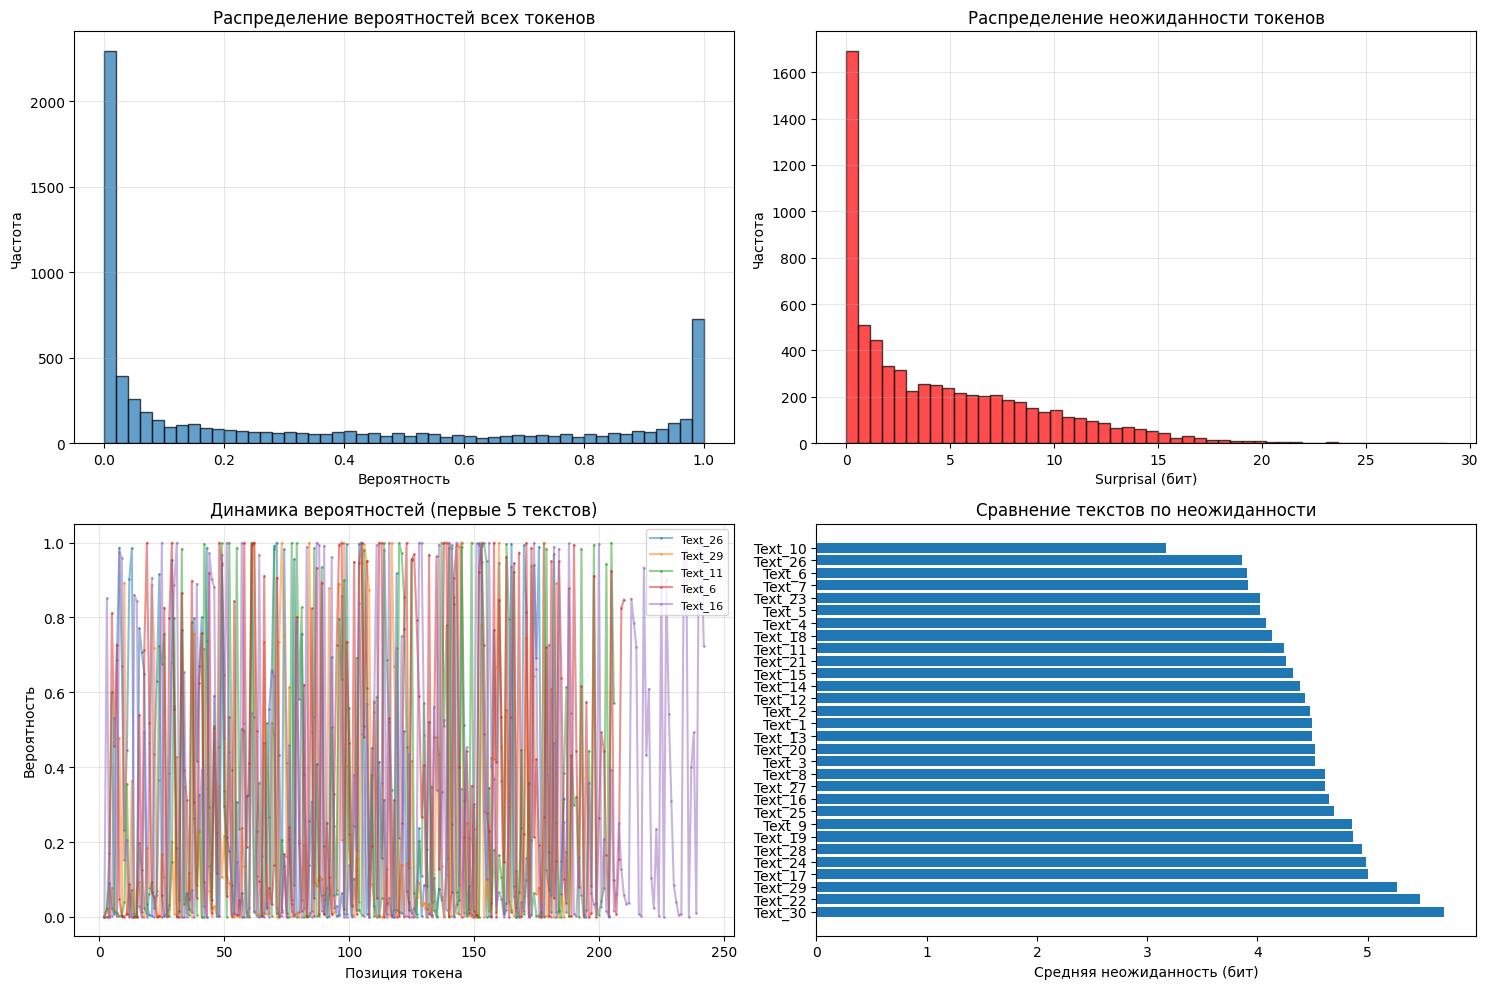


📈 ДОПОЛНИТЕЛЬНАЯ СТАТИСТИКА:
  Text_26: корреляция позиция-вероятность = -0.047
  Text_29: корреляция позиция-вероятность = 0.107
  Text_11: корреляция позиция-вероятность = 0.080

🔥 ТОП-10 САМЫХ НЕОЖИДАННЫХ ТОКЕНОВ:
text_id  position    token  probability  surprisal
Text_22       119    встал 2.090141e-09  28.833752
Text_27       103    проше 4.120844e-08  24.532485
Text_25       148 начинала 4.647448e-08  24.358986
Text_25       209   восход 5.385613e-08  24.146314
Text_24        57    таком 7.755249e-08  23.620252
 Text_1       223  планета 1.123274e-07  23.085787
Text_25        75    внизу 1.134042e-07  23.072023
Text_14       215      реф 1.649525e-07  22.531446
 Text_2        69       55 2.090978e-07  22.189319
Text_27        19    лесом 2.140871e-07  22.155299

✅ ТОП-10 САМЫХ ПРЕДСКАЗУЕМЫХ ТОКЕНОВ:
text_id  position token  probability    surprisal
 Text_5       192 чевую     1.000000 5.159480e-07
 Text_3       195  сюду     1.000000 6.879308e-07
Text_26       105   чит     0.99

In [ ]:
"""
СКРИПТ 4: АНАЛИЗ РЕЗУЛЬТАТОВ
Визуализация и дополнительный анализ
"""
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import glob
from scipy import stats

print("=" * 60)
print("📊 АНАЛИЗ РЕЗУЛЬТАТОВ")

# Находим все CSV файлы
csv_files = glob.glob("*_probabilities.csv")
print(f"📁 Найдено файлов с результатами: {len(csv_files)}")

if not csv_files:
    print("❌ Нет файлов для анализа. Сначала запустите script3_process_all.py")
    raise SystemExit

# Загружаем все результаты
all_dfs = []
for file in csv_files:
    try:
        df = pd.read_csv(file)
        all_dfs.append(df)
        print(f"  ✅ Загружен: {file} ({len(df)} строк)")
    except:
        print(f"  ❌ Ошибка загрузки: {file}")

if not all_dfs:
    print("❌ Не удалось загрузить ни один файл")
    raise SystemExit

combined_df = pd.concat(all_dfs, ignore_index=True)
print(f"\n📊 ОБЪЕДИНЕННЫЙ ДАТАФРЕЙМ:")
print(f"   • Текстов: {combined_df['text_id'].nunique()}")
print(f"   • Токенов: {len(combined_df):,}")
print(f"   • Столбцы: {list(combined_df.columns)}")

# 1. Гистограмма вероятностей
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.hist(combined_df['probability'], bins=50, alpha=0.7, edgecolor='black')
plt.xlabel('Вероятность')
plt.ylabel('Частота')
plt.title('Распределение вероятностей всех токенов')
plt.grid(alpha=0.3)

# 2. Гистограмма неожиданности
plt.subplot(2, 2, 2)
plt.hist(combined_df['surprisal'], bins=50, alpha=0.7, color='red', edgecolor='black')
plt.xlabel('Surprisal (бит)')
plt.ylabel('Частота')
plt.title('Распределение неожиданности токенов')
plt.grid(alpha=0.3)

# 3. Динамика вероятностей по текстам
plt.subplot(2, 2, 3)
for text_id in combined_df['text_id'].unique()[:5]:  # Первые 5 текстов
    text_data = combined_df[combined_df['text_id'] == text_id]
    plt.plot(text_data['position'], text_data['probability'],
             alpha=0.5, label=text_id, marker='.', markersize=2)
plt.xlabel('Позиция токена')
plt.ylabel('Вероятность')
plt.title('Динамика вероятностей (первые 5 текстов)')
plt.legend(loc='upper right', fontsize=8)
plt.grid(alpha=0.3)

# 4. Сравнение текстов по средней неожиданности
plt.subplot(2, 2, 4)
summary_by_text = combined_df.groupby('text_id').agg({
    'surprisal': 'mean',
    'probability': 'mean'
}).reset_index()

summary_by_text = summary_by_text.sort_values('surprisal', ascending=False)
plt.barh(summary_by_text['text_id'], summary_by_text['surprisal'])
plt.xlabel('Средняя неожиданность (бит)')
plt.title('Сравнение текстов по неожиданности')
plt.tight_layout()

plt.show()

# Дополнительный анализ
print("\n📈 ДОПОЛНИТЕЛЬНАЯ СТАТИСТИКА:")

# Корреляция между вероятностью и позицией
for text_id in combined_df['text_id'].unique()[:3]:
    text_data = combined_df[combined_df['text_id'] == text_id]
    if len(text_data) > 10:
        corr = np.corrcoef(text_data['position'], text_data['probability'])[0, 1]
        print(f"  {text_id}: корреляция позиция-вероятность = {corr:.3f}")

# Топ самых неожиданных токенов
print("\n🔥 ТОП-10 САМЫХ НЕОЖИДАННЫХ ТОКЕНОВ:")
top_surprising = combined_df.nlargest(10, 'surprisal')[['text_id', 'position', 'token', 'probability', 'surprisal']]
print(top_surprising.to_string(index=False))

# Топ самых предсказуемых токенов
print("\n✅ ТОП-10 САМЫХ ПРЕДСКАЗУЕМЫХ ТОКЕНОВ:")
top_predictable = combined_df.nsmallest(10, 'surprisal')[['text_id', 'position', 'token', 'probability', 'surprisal']]
print(top_predictable.to_string(index=False))

# Сохраняем полный датафрейм для дальнейшего анализа
combined_df.to_csv('ALL_RESULTS_COMBINED.csv', index=False, encoding='utf-8-sig')
print(f"\n💾 Полные результаты сохранены: ALL_RESULTS_COMBINED.csv")

# Анализ по типам токенов
print("\n🔤 АНАЛИЗ ПО ТИПАМ ТОКЕНОВ:")

def categorize_token(token):
    """Категоризация токенов"""
    if not token:
        return 'пустой'
    elif token.isspace():
        return 'пробел'
    elif token.isalpha():
        if len(token) == 1:
            return 'однобуквенное'
        else:
            return 'слово'
    elif token.isdigit():
        return 'цифра'
    elif token in '.,!?;:()[]{}"\'«»':
        return 'пунктуация'
    else:
        return 'другое'

combined_df['token_type'] = combined_df['token'].apply(categorize_token)

type_stats = combined_df.groupby('token_type').agg({
    'probability': ['count', 'mean', 'std'],
    'surprisal': ['mean', 'std']
}).round(4)

print(type_stats)

# Сохраняем анализ по типам
type_stats.to_csv('token_type_analysis.csv')
print("💾 Анализ по типам токенов сохранен: token_type_analysis.csv")

In [ ]:
"""
СКРИПТ 5: СКАЧИВАНИЕ РЕЗУЛЬТАТОВ
"""
import zipfile
import os
import glob
from google.colab import files

print("=" * 60)
print("📥 СКАЧИВАНИЕ РЕЗУЛЬТАТОВ")

# Список файлов для архивации
files_to_zip = []
files_to_zip.extend(glob.glob("*_probabilities.csv"))
files_to_zip.extend(glob.glob("*.csv"))  # Все CSV файлы
files_to_zip = list(set(files_to_zip))  # Убираем дубликаты

print(f"📁 Файлов для архивации: {len(files_to_zip)}")

if not files_to_zip:
    print("❌ Нет результатов для скачивания")
    raise SystemExit

# Создаем ZIP архив
zip_filename = "text_processing_results.zip"

with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for file in files_to_zip:
        if os.path.exists(file):
            zipf.write(file)
            print(f"  📎 Добавлен: {file}")

print(f"\n✅ Создан архив: {zip_filename}")
print(f"   Размер: {os.path.getsize(zip_filename) / 1024:.1f} KB")

# Скачивание
print("\n⏬ СКАЧИВАНИЕ...")
files.download(zip_filename)

print("\n📋 СОДЕРЖИМОЕ АРХИВА:")
with zipfile.ZipFile(zip_filename, 'r') as zipf:
    for info in zipf.infolist():
        print(f"  • {info.filename} ({info.file_size / 1024:.1f} KB)")

print("\n🎉 ГОТОВО! Все файлы скачаны.")

📥 СКАЧИВАНИЕ РЕЗУЛЬТАТОВ
📁 Файлов для архивации: 33
  📎 Добавлен: processing_summary.csv
  📎 Добавлен: Text_7_probabilities.csv
  📎 Добавлен: Text_25_probabilities.csv
  📎 Добавлен: Text_13_probabilities.csv
  📎 Добавлен: Text_1_probabilities.csv
  📎 Добавлен: Text_21_probabilities.csv
  📎 Добавлен: Text_14_probabilities.csv
  📎 Добавлен: ALL_RESULTS_COMBINED.csv
  📎 Добавлен: Text_19_probabilities.csv
  📎 Добавлен: Text_3_probabilities.csv
  📎 Добавлен: Text_29_probabilities.csv
  📎 Добавлен: Text_15_probabilities.csv
  📎 Добавлен: Text_28_probabilities.csv
  📎 Добавлен: Text_26_probabilities.csv
  📎 Добавлен: Text_20_probabilities.csv
  📎 Добавлен: Text_6_probabilities.csv
  📎 Добавлен: Text_23_probabilities.csv
  📎 Добавлен: Text_2_probabilities.csv
  📎 Добавлен: Text_5_probabilities.csv
  📎 Добавлен: Text_4_probabilities.csv
  📎 Добавлен: Text_8_probabilities.csv
  📎 Добавлен: token_type_analysis.csv
  📎 Добавлен: Text_18_probabilities.csv
  📎 Добавлен: Text_12_probabilities.csv
  

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


📋 СОДЕРЖИМОЕ АРХИВА:
  • processing_summary.csv (1.9 KB)
  • Text_7_probabilities.csv (24.1 KB)
  • Text_25_probabilities.csv (28.8 KB)
  • Text_13_probabilities.csv (21.9 KB)
  • Text_1_probabilities.csv (26.1 KB)
  • Text_21_probabilities.csv (24.8 KB)
  • Text_14_probabilities.csv (26.7 KB)
  • ALL_RESULTS_COMBINED.csv (731.6 KB)
  • Text_19_probabilities.csv (24.8 KB)
  • Text_3_probabilities.csv (27.1 KB)
  • Text_29_probabilities.csv (21.3 KB)
  • Text_15_probabilities.csv (25.9 KB)
  • Text_28_probabilities.csv (28.2 KB)
  • Text_26_probabilities.csv (19.6 KB)
  • Text_20_probabilities.csv (23.8 KB)
  • Text_6_probabilities.csv (21.3 KB)
  • Text_23_probabilities.csv (27.2 KB)
  • Text_2_probabilities.csv (25.1 KB)
  • Text_5_probabilities.csv (24.9 KB)
  • Text_4_probabilities.csv (23.0 KB)
  • Text_8_probabilities.csv (20.5 KB)
  • token_type_analysis.csv (0.3 KB)
  • Text_18_probabilities.csv (26.7 KB)
  • Text_12_probabilities.csv (26.5 KB)
  • Text_27_probabilities.csv (24